# Identification and visualization of similar sequences in digital sheet music - Bach corpus

## 1 Setting environments and importing necessary packages (tested only on Windows)

###  <font color='blue'> Install MuseScore 3 is necessary for visualization purposes </font>

#### <font color='red'> Download link: https://musescore.org/en/download </font>

In [ ]:
 !pip install -r requirements.txt

In [1]:
import re
import math
import ast 
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams 
from music21 import *
from pathlib import Path 
import pandas as pd
import os 
from os import listdir
from os.path import isfile, join
from itertools import groupby
import glob
from difflib import SequenceMatcher
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import display, Markdown, clear_output

# widget and UX packages
from ipywidgets import widgets, interact
from tqdm.notebook import trange, tqdm
from tkinter import Tk, filedialog


us = environment.UserSettings()

#Only for Windows - install and add your path of MuseScore3 here
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

## 2 Algorithms for extracting information from digital sheet note

### Function to convert fraction objects to floats

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        decimal = whole - frac if whole < 0 else whole + frac
        return round(decimal,3)

### Extracts measure information from sheet parts

In [3]:
def get_measure_and_notes(part):
    measures = []
    detailed_seq = [] #Whole note part sequence without meassure markings
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        
        for elem in newMeasure[e.number]:
            off_s = elem.offset
            if elem.isNote:
                
                if not isinstance(elem.duration.quarterLength, float) or not isinstance(off_s, float):
                    
                    decimal_lenght = convert_to_float(str(elem.duration.quarterLength))
                    off_s = convert_to_float(str(off_s))
                    detailed_seq.append((e.number, str(elem.pitch.midi), decimal_lenght, off_s))
                   
                else:
                    
                    detailed_seq.append((e.number, str(elem.pitch.midi), elem.duration.quarterLength, off_s))
                
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                notes = []
                
                for c in elem.notes:
                    if not isinstance(c.duration.quarterLength, float) or not isinstance(off_s, float):
                        decimal_lenght = convert_to_float(str(c.duration.quarterLength))
                        off_s = convert_to_float(str(off_s))
                        notes.append((e.number, str(c.pitch.midi),decimal_lenght, off_s))
                    else:
                        notes.append((e.number, str(c.pitch.midi), c.duration.quarterLength, off_s))
                        
                detailed_seq.append(notes)
            elif elem.isRest:
                detailed_seq.append((e.number, str(elem.name) + '_'+ str(elem.duration.quarterLength)))
        
        measures.append(newMeasure)

    
    dic = {}
    
    for i in range(len(detailed_seq)):
        if len(detailed_seq[i]) != 0:
            dic[i] = detailed_seq[i]
    return dic


### Sheet note information is extracted to datatable

In [4]:
def gather_part_info(note, noteName, sheet_path, note_id, k_old, k_new):
    allNote = [] #Every part of the instrument is collected here
    part_count = 1
    for el in note.elements: #Every part is a separately analyzed -> el = PartStaff
        #Basic info
        partList = {}
        partList['note_id'] = note_id
        partList['note_part_id'] = str(note_id) + "_" + str(part_count)
        partList['sheet_name'] = noteName
        partList['sheet_path'] = sheet_path
        partList['partName'] = el.partName 
        partList['original_key'] = k_old 
        
        part_count +=1
 
        partList['transposed_key'] = k_new
            
        #Find time signature
        time_signatures = []
        for i in (el['TimeSignature']):
            time_signatures.append(str(i.numerator) + '/' + str(i.denominator))
        if len(set(time_signatures)) == 0:
            partList['time_signature'] = "None"
        elif len(set(time_signatures)) == 1:
            partList['time_signature'] = time_signatures[0]
        else:
            partList['time_signature'] = set(time_signatures)
        
        #Find the Metronome
        metronome = []
        for i in el['MetronomeMark']: 
            metronome.append(str(i.number))
        if len(set(metronome)) == 0:
            partList['bpm (quarter note)'] = "None" #MuseScore gives a default of 120.
        elif len(set(metronome)) == 1:
            partList['bpm (quarter note)'] = metronome[0]
        else:
            partList['bpm (quarter note)'] = set(metronome)
            
        #Find the measures and their content
        partList['measures'] = get_measure_and_notes(el)
        
        allNote.append(partList)
    return allNote

### Key change algoritm (to base key - C major or a minor)

In [5]:
#Change all keys to either a-minor or C-major
def key_change_to_base(note): 
    
    k = note.analyze('key')
    
    if 'major' in str(k):
        i = interval.Interval(k.tonic, pitch.Pitch('c'))
    else:
        i = interval.Interval(k.tonic, pitch.Pitch('a'))
    sNew = note.transpose(i)
    kNew = sNew.analyze('key')

    
    return k, kNew, sNew

## 3 Importing sheet notes to dataframe

## Bach's corpus analysis 
#### (last index is 412, after that are .krn files which are not included)

In [6]:
def construct_bach_corpus_df(key_change):
    
    file_exists = os.path.exists("bach_corpus.csv") 
    
    if file_exists:
        df = pd.read_csv("bach_corpus.csv", index_col=[0])
        return df
    else:
    
        list_of_music = []
        paths = corpus.getComposer('bach')
        for i in paths:
            list_of_music.append(i.name)

        bach_notes = list_of_music[0:413]
        lst_note_info = []
        for note_idx in tqdm(range(len(bach_notes))):
            if '.mxl' in bach_notes[note_idx]:
                s = corpus.parse('bach/' + bach_notes[note_idx])
                if key_change:
                    k_old,k_new, sNew = key_change_to_base(s)
                    partStream2 = sNew.parts.stream()
                else:
                    partStream2 = s.parts.stream()
                if len(lst_note_info) == 0:
                    idx = 0
                else:
                    idx = lst_note_info[-1]['note_id']

                note_info2= gather_part_info(partStream2, bach_notes[note_idx], 'corpus', idx+1, k_old, k_new)
                for elem in note_info2:
                    lst_note_info.append(elem)

        df = pd.DataFrame(lst_note_info)
        df.to_csv("./bach_corpus.csv")
    return df

df_complete = construct_bach_corpus_df(True)
df_complete

,note_id,note_part_id,sheet_name,sheet_path,partName,original_key,transposed_key,time_signature,bpm (quarter note),measures
0,1,1_1,bwv1.6.mxl,corpus,Horn 2,F major,C major,4/4,None,"{0: (0, '60', 1.0, 0.0), 1: (1, '62', 0.5, 0.0..."
1,1,1_2,bwv1.6.mxl,corpus,Soprano,F major,C major,4/4,None,"{0: (0, '60', 1.0, 0.0), 1: (1, '67', 1.0, 0.0..."
2,1,1_3,bwv1.6.mxl,corpus,Alto,F major,C major,4/4,None,"{0: (0, '55', 1.0, 0.0), 1: (1, '55', 1.0, 0.0..."
3,1,1_4,bwv1.6.mxl,corpus,Tenor,F major,C major,4/4,None,"{0: (0, '52', 1.0, 0.0), 1: (1, '50', 1.0, 0.0..."
4,1,1_5,bwv1.6.mxl,corpus,Bass,F major,C major,4/4,None,"{0: (0, '48', 1.0, 0.0), 1: (1, '47', 1.0, 0.0..."
...,...,...,...,...,...,...,...,...,...,...
1750,407,407_7,bwv97.9.mxl,corpus,Bass,B- major,C major,4/4,None,"{0: (0, '36', 1.0, 0.0), 1: (1, '48', 1.0, 0.0..."
1751,408,408_1,bwv99.6.mxl,corpus,Soprano,G major,C major,4/4,None,"{0: (0, '55', 1.0, 0.0), 1: (1, '60', 1.0, 0.0..."
1752,408,408_2,bwv99.6.mxl,corpus,Alto,G major,C major,4/4,None,"{0: (0, '52', 0.5, 0.0), 1: (0, '53', 0.5, 0.5..."
1753,408,408_3,bwv99.6.mxl,corpus,Tenor,G major,C major,4/4,None,"{0: (0, '48', 0.5, 0.0), 1: (0, '50', 0.5, 0.5..."


In [7]:
df_complete.head(10)

,note_id,note_part_id,sheet_name,sheet_path,partName,original_key,transposed_key,time_signature,bpm (quarter note),measures
0,1,1_1,bwv1.6.mxl,corpus,Horn 2,F major,C major,4/4,None,"{0: (0, '60', 1.0, 0.0), 1: (1, '62', 0.5, 0.0..."
1,1,1_2,bwv1.6.mxl,corpus,Soprano,F major,C major,4/4,None,"{0: (0, '60', 1.0, 0.0), 1: (1, '67', 1.0, 0.0..."
2,1,1_3,bwv1.6.mxl,corpus,Alto,F major,C major,4/4,None,"{0: (0, '55', 1.0, 0.0), 1: (1, '55', 1.0, 0.0..."
3,1,1_4,bwv1.6.mxl,corpus,Tenor,F major,C major,4/4,None,"{0: (0, '52', 1.0, 0.0), 1: (1, '50', 1.0, 0.0..."
4,1,1_5,bwv1.6.mxl,corpus,Bass,F major,C major,4/4,None,"{0: (0, '48', 1.0, 0.0), 1: (1, '47', 1.0, 0.0..."
5,2,2_1,bwv10.7.mxl,corpus,Soprano,g minor,a minor,4/4,None,"{0: (1, '76', 2.0, 0.0), 1: (1, '79', 2.0, 2.0..."
6,2,2_2,bwv10.7.mxl,corpus,Alto,g minor,a minor,4/4,None,"{0: (1, '69', 2.0, 0.0), 1: (1, '67', 2.0, 2.0..."
7,2,2_3,bwv10.7.mxl,corpus,Tenor,g minor,a minor,4/4,None,"{0: (1, '60', 2.0, 0.0), 1: (1, '62', 2.0, 2.0..."
8,2,2_4,bwv10.7.mxl,corpus,Bass,g minor,a minor,4/4,None,"{0: (1, '57', 2.0, 0.0), 1: (1, '59', 2.0, 2.0..."
9,3,3_1,bwv101.7.mxl,corpus,Soprano,d minor,a minor,4/4,None,"{0: (0, '76', 1.0, 0.0), 1: (1, '76', 1.0, 0.0..."


## 4 Longest Common Consequtive Non-overlapping Subsequence

### Sheet music information extracting and transformation algorithms for LCCNOS analysis

#### Measures are assembled as following: - [a,b,c,d]

* a - measure nr. / index
* b - MIDI mark of the note (can retreive note pitch and note octave from it)
* c - duration of the note
* d - float = off-beat note/element, integer = on-beat note/element

### Removing rests

In [8]:
def remove_rests(lst):
    for el in lst:
        elem = el[1]
       
        if 'rest_' in elem[1]:
            lst.remove(el)
    return lst

### Removing off-beat notes

In [9]:
def remove_offbeat(lst):
    lst_new = remove_rests(lst)
    new_lst = []
    for el in lst_new:
        elem = el[1]
       
        if isinstance(elem, list):
            if elem[0][-1].is_integer():
                new_lst.append((el[0],elem))
        else:
            
            if type(elem[-1]) == str:
                lst_new.remove(el)
            else:
                
                if elem[-1].is_integer():
                    new_lst.append((el[0], elem))
    return new_lst

### Removing repetitive notes

In [10]:
def remove_repetitive_notes(lst):
    
    return [x[0] for x in groupby(lst)]

### Construct the string from note information

**Possible values of variables:**

* n -> measure list from dataframe row
* if_rest -> True: keep the rests, False: remove the rests
* if_chords -> True: keep the chords, False: remove the chords and keep only the highest note of the chord
* o = 2 -> if note duration is NOT taken into account OR o = 3 -> if note duration IS taken into account
* offset -> True: keep the offset notes, False: remove offset notes 
* repetition -> True: keep the repetitive notes, False: remove the repetitive (aka consequtive same) notes

In [11]:
def construct_strings(n, if_rest, if_chords, o, offset, repetition):

    if isinstance(n, str):
        n = ast.literal_eval(n)
        
    n = ([(k, n[k]) for k in n]) #change dict to list value

    #Remove repetition first if needed
    if repetition == False:
        n = remove_repetitive_notes(n)

    lst = []
    lst_keys = []
    #Remove offset notes
    if offset == False: 
        n = remove_offbeat(n)
        
    

    for el in n:
        i = el[1]
        if if_rest:
            if 'rest' in i[1]:
                continue #skipping rests
        if isinstance(i, list):
            if if_chords: #Takes the first note of the chord into account
                elem = i[0][1:o]
                s = ' '.join(map(str,elem))
                lst.append(s)
                lst_keys.append(el[0])
            else: #Takes the whole chord into account
                cover_lst = []
                for elem in i:

                    elem = elem[1:3]
                    cover_lst.append(elem)
                s = ' '.join(map(str,cover_lst))
                lst.append(s)
                lst_keys.append(el[0])
        else:
            if 'rest' in i[1]:
                i = i[1:2]
                s = ' '.join(map(str,i))
                lst.append(s)
                lst_keys.append(el[0])
            else:
                i = i[1:o]
                s = ' '.join(map(str,i))
                lst.append(s)
                lst_keys.append(el[0])
   
    return lst, lst_keys

### Generating n-grams and matching sequences - O(N²) — Quadratic Time:

In [12]:
def generate_ngrams(s, n):
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    
    ngrams = zip(*[s[i:] for i in range(n)])

    return [ngram for ngram in ngrams]

def match_seq(list1,list2):
    output=[]
    s = SequenceMatcher(None, list1, list2)
   
    blocks=s.get_matching_blocks()
    for bl in blocks:
        for bi in range(bl.size):
            cur_a=bl.a+bi
            cur_b=bl.b+bi
            output.append((cur_a,cur_b))
    return output

def matched_seq_analysis(a, b, ngram, a_keys, b_keys):
    
    matched_seq=[]
    
    a_gram = generate_ngrams(a,ngram)
    b_gram = generate_ngrams(b,ngram)
    
    
    for x,y in match_seq(a_gram,b_gram): #x and y represent the 'number order of the specific note'
        
        k = list(a_gram[x])
        k2 = list(b_gram[y])
        
        idxs_a = [(i, i+len(k)) for i in range(len(a)) if a[i:i+len(k)] == k]
        idxs_b = [(i, i+len(k2)) for i in range(len(b)) if b[i:i+len(k2)] == k2]
        
        a_gram_keys = a_keys[idxs_a[0][0]:idxs_a[0][1]]
        b_gram_keys = b_keys[idxs_b[0][0]:idxs_b[0][1]]
        
        matched_seq.append((x,y,a_gram[x],b_gram[y], a_gram_keys, b_gram_keys))
        
    return matched_seq

## Find Different Longest Consecutive Non-Overlapping Subsequences between two strings

### Finding the longest common subsequence (starting from 4-gram)

#### Total maches = (x,y, a_gram[x],b_gram[y], a_gram_keys, b_gram_keys)

* x - the order of the note from the part from where does the matched sequence start, for searching unique non-overlapping sequences
* y - the order of the note from the second part from where does the mached sequence start, for searching unique non-overlapping sequences
* a_gram[x] - the matched sequence in midi notes
* b_gram[y] - the matched sequence in midi notes
* a_gram_keys - the keys of the first note's notes referring to original notes
* b_gram_keys - the keys of the second note's notes referring to original notes

In [13]:
def LCCNOS(n1, n2, if_rest, if_chords, o, offset, repetition):
    a = construct_strings(n1, if_rest, if_chords, o, offset, repetition) 
    b = construct_strings(n2, if_rest, if_chords, o, offset, repetition)
    
    lst_of_matched_seqs = []
    counter = 4 #Starting to look for ngrams 4 and above
    total_matches = []
    if len(n1) > len(n2):
        
        total = len(n2)
        total_matches = []
        while counter != total: 
            matched = matched_seq_analysis(a[0], b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
                
            counter +=1 
    else:
        total = len(n1)
        total_matches = []
        while counter != total:
            matched = matched_seq_analysis(a[0],b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
               
            counter +=1 
    
    #LCCNOS algorithm
    if len(total_matches) == 0:
        return 0, 0, 0, 0
    else:
        idx1 = total_matches[0][0]
        idx2 = total_matches[0][1]
        seq_length = len(total_matches[0][3])

        found_matches = []

        range_1 = list(range(idx1, idx1+(counter-1)))
        range_2 = list(range(idx2, idx2+(counter-1)))

        while seq_length >= 4:
            
            matched = matched_seq_analysis(a[0], b[0], seq_length, a[1], b[1])

            for match in matched:

                if match[0] not in range_1 or match[1] not in range_2:
                    
                    found_matches.append(match)
                    range_1 = range_1 + list(range(match[0], match[0]+seq_length))
                    range_2 = range_2 + list(range(match[1], match[1]+seq_length))
                    range_1.sort()
                    range_2.sort()
            seq_length= seq_length - 1
        
        
                
        if len(found_matches) == 0:
            found_matches_length = 0
            found_matches = 0
        else:
            found_matches_length = len(found_matches)
        
        
        return total_matches, len(total_matches[0][3]), found_matches, found_matches_length

## Matching the longest common sequences

### Choices of methods:

* Rests:<br>
   a) Keep the rests in the note sequeneces <br>
   b) Remove all the rests from the note sequences <br><br>

* Chords<br>
a) Leave chords as they are - KITSENDUS (võimalik oleks ka kõik akordi noodid lisada või siis määrata ära akordi tähtsaim noot? -> .root()) <br>
b) Only take account the first note (higher note) of the chord (chord can be harmony starting from 2 consequently sounding notes)<br><br>

* Note duration<br>
a) Consider note duration in the sequence matching<br>
b) Do not consider note duration (note can be in any duration as long as it is the same consequtive note - then it will match)<br><br>

* Offset notes<br>
a) Leave offset (not on beat notes) into the sheet<br>
b) Remove all notes that do not fall on beat<br><br>

* Repetition <br>
a) Same consequitive notes are kept<br>
b) Same consequtive notes are removed<br>

### Datatable   
   
LCCNOS = Longest Common Consequtive Non-Overlapping Sequence

### Construct the rules for LCCNOS method

In [57]:
def construct_LCCNOS(df_base, i, y, complete, parameters):
    
    helper_dictionary = {2:'False', 3: 'True'}
    #Test for only one LCS method

    if not complete:
        
        key = str(df_base['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
        
        #Example method - change it and choose your own
      
        if parameters[2]:
            note_duration = 3
        else:
            note_duration = 2
        
        method = str(parameters[0])[0] + str(parameters[1])[0] + helper_dictionary[note_duration][0] + str(parameters[3])[0] + str(parameters[4])[0]  
        
        
        LCS_x, l, lccnos, l_lccnos = LCCNOS(df_base['measures'][i],df_base['measures'][y], parameters[0], parameters[1], note_duration, parameters[3], parameters[4])
        
        data = {'note_part_ids': key,'LCS': LCS_x, 'length_LCS': l, 'LCCNOS': lccnos, 'size_LCCNOS': l_lccnos, 'method_id': method, 'remove_rests':str(parameters[0]),'remove_chords':str(parameters[1]),
                                   'consider_note_duration': helper_dictionary[note_duration], 'consider_offset_notes':str(parameters[3]), 'consider_repetition':str(parameters[4])}
        
        df_whole = pd.DataFrame([data])
        
    else:
    
    #Computes all the possible method variants
        rests = [True, False]
        chords = [True, False]
        note_duration = [2,3]
        offset_notes = [True, False]
        repetition = [True, False]

        lst_of_rows =[]
        for a in rests:
            for b in chords:
                    for c in note_duration:
                        for d in offset_notes:
                            for e in repetition:

                                method = str(a)[0]+str(b)[0]+helper_dictionary[c][0]+str(d)[0]+str(e)[0]
                                
                                print(method)

                                key = str(df_base['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])

                                LCS_x, l, lccnos, l_lccnos = LCCNOS(df_base['measures'][i],df_base['measures'][y],a,b,c,d,e)

                                data = {'note_part_ids': key,'LCS': LCS_x, 'length_LCS': l, 'LCCNOS':lccnos, 'size_LCCNOS': l_lccnos, 'method_id':method, 'remove_rests':a,'remove_chords':b,
                                       'consider_note_duration':helper_dictionary[c], 'consider_offset_notes':d, 'consider_repetition':e}

                                lst_of_rows.append(data)
        df_whole = pd.DataFrame(lst_of_rows)
                        
    return df_whole

In [45]:
#Look for similar sequence between two different notes OR against all the notes in the dataframe
def LCCNOS_analysis(df_base, i, one_note_bool, if_complete, parameters):
    df_whole = pd.DataFrame()
    note_dict = {}
    
    if one_note_bool != -1: #Compare to all the notes in the dataframe
        
        y =  one_note_bool
        df_whole = construct_LCCNOS(df_base, i, y, if_complete, parameters)
        
    else: #Compare to specific note in the dataframe (based on index)
        for y in range(len(df_base)):
            if i !=y:
                df_part = construct_LCCNOS(df_base, i, y, if_complete, parameters)
                df_whole = df_whole.append(df_part, ignore_index = True) 
                
    return df_whole

# Choose a bach note you want to compare against the dataframe notes

### <font color='blue'>Choose a method from the options:</font>

In [46]:
import ipywidgets as widgets

wid1 = widgets.Checkbox(
    value=False,
    description='Remove rests',
    disabled=False
)
wid2 = widgets.Checkbox(
    value=False,
    description='Remove chords',
    disabled=False
)


wid3 = widgets.Checkbox(
    value=True,
    description='Consider note duration',
    disabled=False
)

wid4 = widgets.Checkbox(
    value=True,
    description='Consider offset notes',
    disabled=False
)

wid5 = widgets.Checkbox(
    value=True,
    description='Consider repetitive notes',
    disabled=False
)


items = [wid1,wid2, wid3, wid4, wid5]
left_box = widgets.VBox([items[0], items[1]])
middle_box = widgets.VBox([items[2], items[3]])
right_box = widgets.VBox([items[4]])
widgets.HBox([left_box, middle_box, right_box])

### LCCNOS_analysis (dataframe, input_note_idx, target_note_idx, methods_boolean):

* dataframe - Choose the dataframe (by default: 'df')
* input_note_idx - Choose a note part you want to analyze based on df_input_note dataframe index (by default: 0)
* target_note_idx - Choose a target note you want to compare the input note against OR write -1 for analysis against all the notes in the dataframe
* methods_boolean - TRUE - note part will be compared with all the 64 methods, FALSE - note part will be compared with one chosen method in 'parameters'
* parameters - checked boxes of method options





### <font color='blue'>Do you want to compare the note with all the methods or only chosen one?</font>

In [47]:
layout = widgets.Layout(width='auto', height='40px') #set width and height

wid6 = widgets.Checkbox(
    value=False,
    description='Compare note parts with every (32 different) method combination',
    disabled=False,
    layout=layout,
    indent=False,
    font_size = 25
)
items = [wid6]
left_box = widgets.VBox([items[0]])
widgets.HBox([left_box])

### <font color='blue'>Add the note index of the input note</font>

In [48]:
input_note_idx = 6 #Add the note index here what you want to compare:

### <font color='blue'>Choose - do you want to compare with all the notes (value: -1) or a specific note (choose target note index value)</font>

In [49]:
target_note_idx = -1 #Change the value here

In [55]:
parameters = [wid1.value, wid2.value, wid3.value, wid4.value, wid5.value, wid6.value]

df_whole = LCCNOS_analysis(df_complete, input_note_idx, target_note_idx, wid6.value, parameters) 
df_whole = df_whole.sort_values(['length_LCS', 'size_LCCNOS'], ascending=[False, False])

,note_part_ids,LCS,length_LCS,LCCNOS,size_LCCNOS,method_id,remove_rests,remove_chords,consider_note_duration,consider_offset_notes,consider_repetition
31904,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TTFTT,True,True,False,True,True
31905,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TTFTF,True,True,False,True,False
31906,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TTFFT,True,True,False,False,True
31907,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TTFFF,True,True,False,False,False
31912,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TFFTT,True,False,False,True,True
31913,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TFFTF,True,False,False,True,False
31914,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TFFFT,True,False,False,False,True
31915,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,TFFFF,True,False,False,False,False
31920,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,FTFTT,False,True,False,True,True
31921,2_2 + 226_2,"[(0, 0, (69...",14,"[(16, 18, (...",1,FTFTF,False,True,False,True,False


In [ ]:
with pd.option_context('display.max_colwidth', 15):
    display(df_whole.head(10))

### <font color='blue'>OPTIONAL: Save the restuls to a .csv file </font>

In [43]:
df_whole.to_csv('bach_analysis_result.csv')

## 4 Visualization

### Algorithms for visualizing subs

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_subs(name1, name2, part_id_1, part_id_2, seq1, seq2):
    
    #if it's a Bach corpus note or note from local directory
    if 'bwv' in name1:
        s1 = corpus.parse('bach/'+name1)
    else:
        s1 = converter.parse(name1)
        
    if 'bwv' in name2:
        s2 = corpus.parse('bach/'+name2)
    else:
        s2 = converter.parse(name2)
    
    k_old1, k_new1, sNew1 = key_change_to_base(s1)
    partStream1 = sNew1.parts.stream()
    k_old1, k_new1, sNew2 = key_change_to_base(s2)
    partStream2 = sNew2.parts.stream()
    
    print(seq1)
    print(seq2)
    print('-----')
    print('Length of the similar note sequence is: ' + str(len(seq1)))
    sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).show()
    sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).show()
    
    sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).show('midi')
    sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).show('midi')
    
    
    return sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).plot().run(), sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).plot().run()

## References back to original notes 

In [35]:
def separate_note_names(notes):
    
    splitted_note_names = notes.split()
   
    note1 = splitted_note_names[0]
    note2 = splitted_note_names[2]

    return note1, note2

def get_actual_notes(notes, idxs):
    
    actual_notes = []
    for i in idxs:
        actual_notes.append(notes[i])
    
    return actual_notes

def get_whole_actual_seq(notes, idxs):
    
    actual_seq = []
    
    start_id = idxs[0]
    end_id = idxs[-1]
    
    while start_id != end_id:
        actual_seq.append(notes[start_id])
        start_id= start_id +1 
      
    return actual_seq
        
def get_notes(notes, lcs, df_base):
    
    note1, note2 = separate_note_names(notes)
    
    part_a_measures = df_base.loc[df_base['note_part_id'] == note1]['measures'].values[0]
    part_b_measures = df_base.loc[df_base['note_part_id'] == note2]['measures'].values[0]
    
    if isinstance(part_a_measures, str):
        part_a_measures = ast.literal_eval(part_a_measures)
        part_b_measures = ast.literal_eval(part_b_measures)
    
    
    part_a_notes_idxs  = lcs[0][4]
    part_b_notes_idxs  = lcs[0][5]
    
    part_a_actual_notes = get_actual_notes(part_a_measures,part_a_notes_idxs)
    part_b_actual_notes = get_actual_notes(part_b_measures,part_b_notes_idxs)
        
    part_a_actual_seq = get_whole_actual_seq(part_a_measures,part_a_notes_idxs)
    part_b_actual_seq = get_whole_actual_seq(part_b_measures,part_b_notes_idxs)
    
    if df_base['sheet_path'].values[0] == 'corpus':
        
        n1_name = df_base.loc[df_base['note_part_id'] == note1]['sheet_name'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_name'].values[0]
        
    else:
        
        n1_name = df_base.loc[df_base['note_part_id'] == note1]['sheet_path'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_path'].values[0]

    splitted_note_names = notes.split()
    
    part_id_1 = splitted_note_names[0].split('_')[-1]
    part_id_2 = splitted_note_names[2].split('_')[-1]
        
    print(n1_name)
    print(n2_name)
    visualize_subs(n1_name, n2_name, part_id_1, part_id_2, part_a_actual_seq, part_b_actual_seq)

## Visualizing best match of longest common subsequence

### <font color='blue'>Change the df_idx value if you want to visualize a specific result</font>

In [36]:
df_idx = 0 # Change this value here

bwv10.7.mxl
bwv323.mxl
[(1, '69', 2.0, 0.0), (1, '67', 2.0, 2.0), (2, '67', 1.0, 0.0), (2, '68', 1.0, 1.0), (2, '69', 1.0, 2.0), (2, '71', 1.0, 3.0), (3, '69', 1.0, 0.0), (3, '67', 2.0, 1.0), (3, '69', 1.0, 3.0), (4, '69', 2.0, 0.0), (4, '67', 2.0, 2.0), (5, '67', 4.0, 0.0), (6, '67', 4.0, 0.0)]
[(1, '69', 2.0, 0.0), (1, '67', 2.0, 2.0), (2, '67', 1.0, 0.0), (2, '68', 1.0, 1.0), (2, '69', 1.0, 2.0), (2, '71', 1.0, 3.0), (3, '69', 1.0, 0.0), (3, '67', 2.0, 1.0), (3, '69', 1.0, 3.0), (4, '69', 2.0, 0.0), (4, '67', 2.0, 2.0), (5, '67', 4.0, 0.0), (6, '67', 4.0, 0.0)]
-----
Length of the similar note sequence is: 13


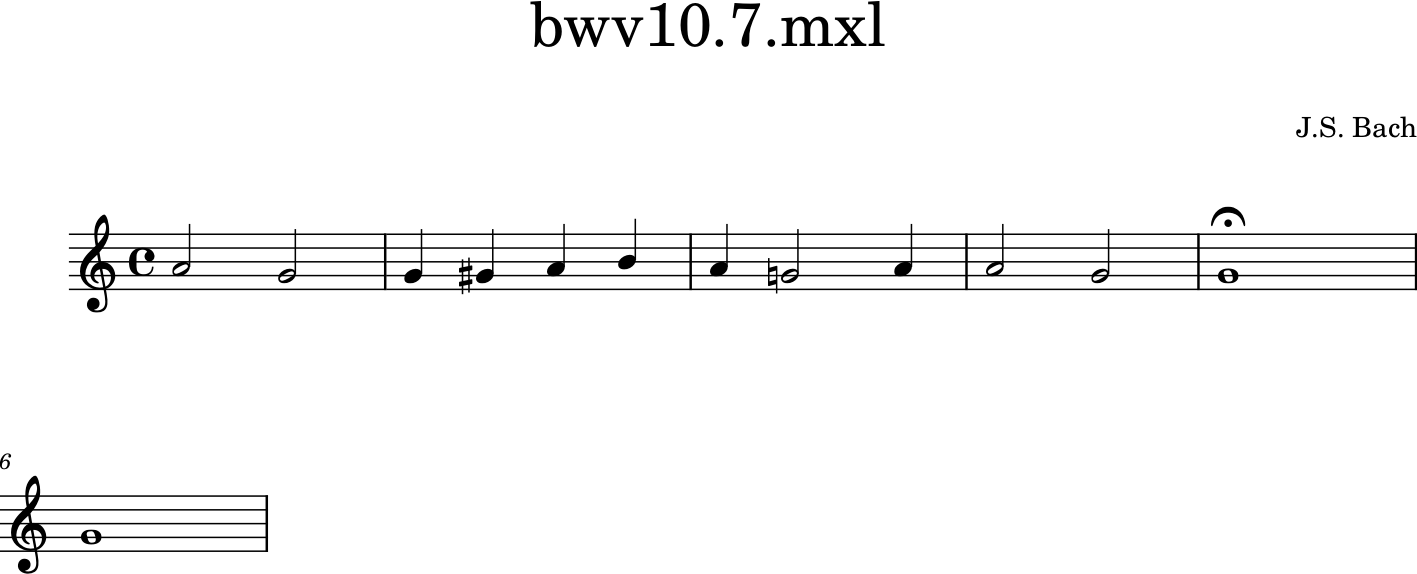

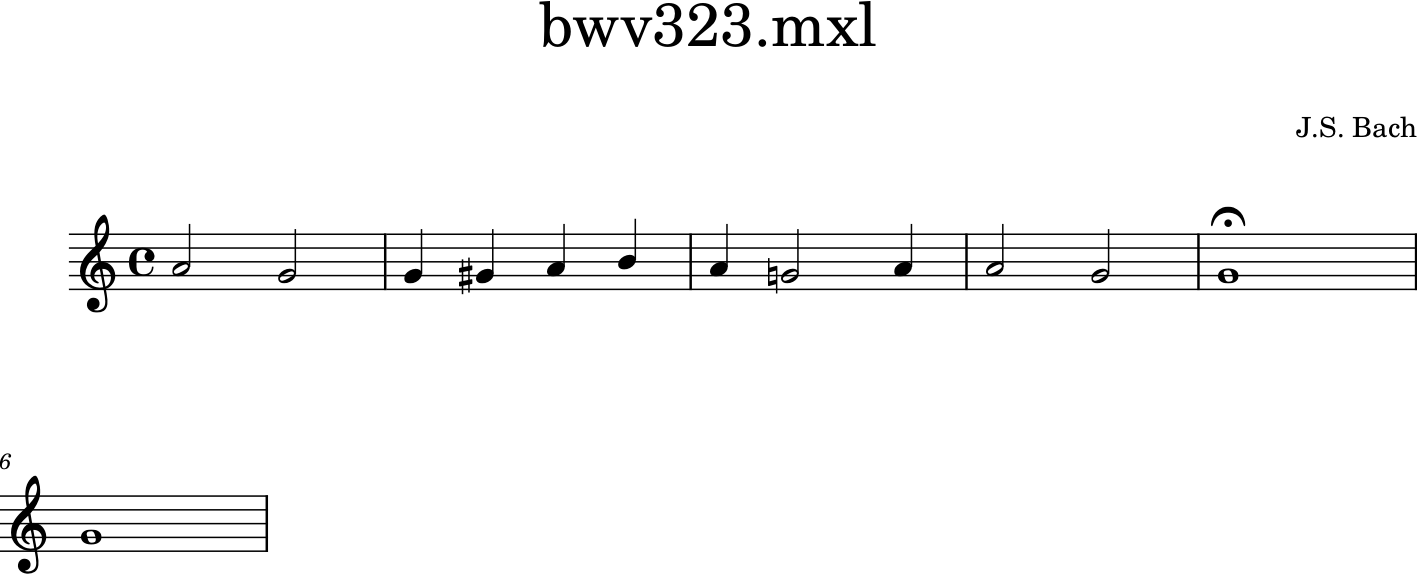

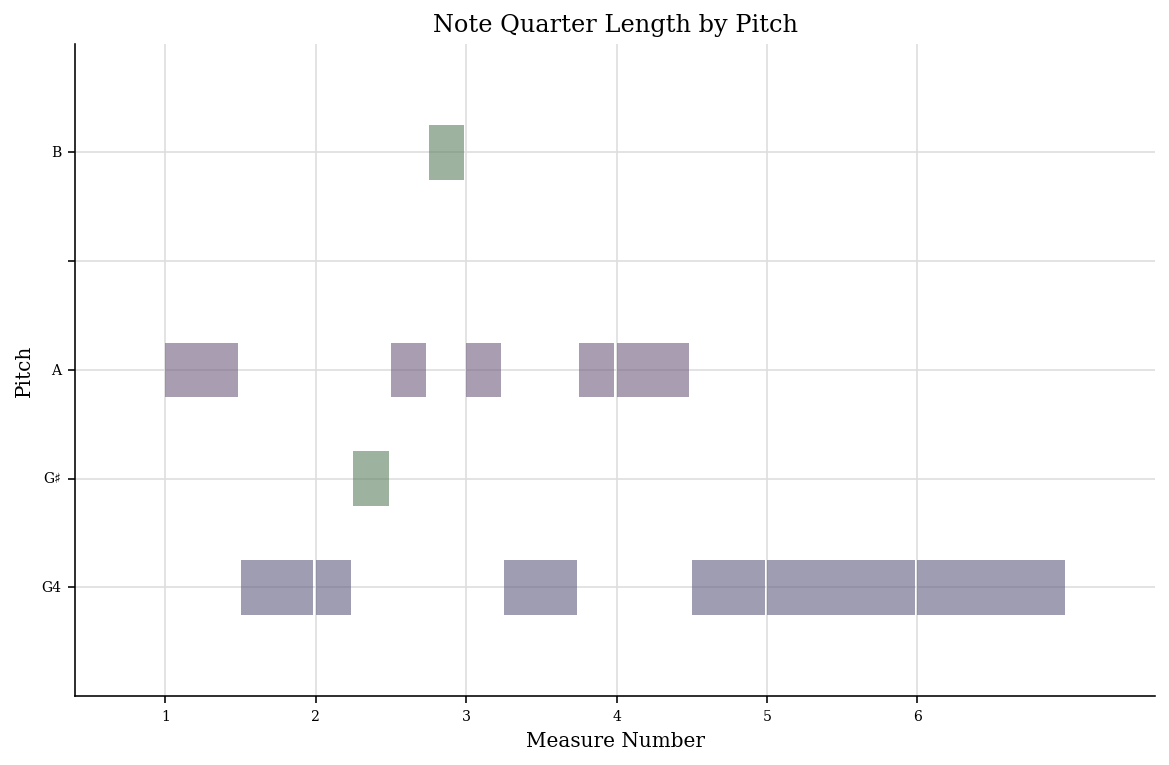

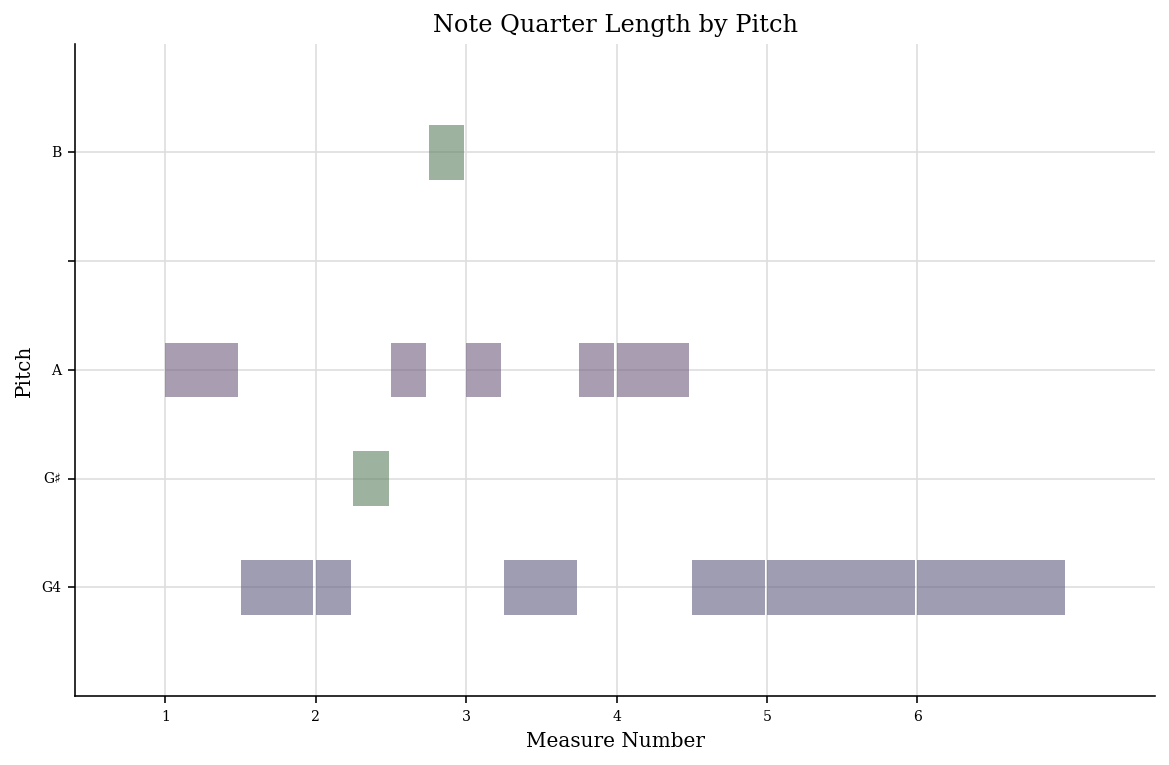

In [38]:
get_notes(df_whole['note_part_ids'].iloc[df_idx], df_whole['LCS'].iloc[df_idx], df_complete)

## Visualizing all the longest repeating non-overlapping unique subsequences 

### <font color='blue'>Change the df_idx value if you want to visualize a specific result</font>

In [ ]:
df_idx = 0 # Change this value here

In [ ]:
if df_whole_small['LCCNOS'].iloc[df_idx] != 0:
    get_notes(df_whole['note_part_ids'].iloc[df_idx], df_whole['LCCNOS'].iloc[df_idx], df_complete)
else:
    print("Value is empty.")

### Add results to Excel file for further analysis

In [ ]:
df_whole_small.to_csv('bach_analysis_results.csv')

****

# End of notebook

***

## Checking differences between key transposing and interval analysis

In [ ]:
def check_semitones(st_inter, intervals):
    if st_inter > 12:
        st_inter = st_inter % 12  
    elif st_inter < -12:
        st_inter = st_inter % -12
    intervals.append(st_inter)
    
def find_intervals(allInfo):
    intervals= []
    i=1 
    while i != len(allInfo) and len(allInfo) != 0 and len(allInfo) != 1:
       
        inter = interval.Interval(noteStart=allInfo[i-1], noteEnd=allInfo[i]).semitones
        check_semitones(inter,intervals)
            
        i+=1
    return intervals

def convert_to_interval(lst):
    n = ([(k, lst[k]) for k in lst])
    lst_1 = remove_rests(n)
    part_notes = []
    intervals = []
    
    
    for elem in lst_1:
        
        if isinstance(elem[1], list):
            continue
        elif 'rest' in elem[1][1]:
            continue
        else:
            n_int = int(elem[1][1])
        n = note.Note(n_int).nameWithOctave
        new_n = note.Note(n)
        part_notes.append(new_n)
    
    new_lst = find_intervals(part_notes)
    
    #print(new_lst)
    return new_lst

In [ ]:
def construct_bach_corpus_df(key_change):
    
    list_of_music = []
    paths = corpus.getComposer('bach')
    for i in paths:
        list_of_music.append(i.name)

    bach_notes = list_of_music[0:413]
    lst_note_info = []
    for note_idx in tqdm(range(len(bach_notes))):
        if '.mxl' in bach_notes[note_idx]:
            s = corpus.parse('bach/' + bach_notes[note_idx])
            k_old,k_new,sNew = key_change_to_base(s)
            partStream2 = s.parts.stream()
            if len(lst_note_info) == 0:
                idx = 0
            else:
                idx = lst_note_info[-1]['note_id']

            note_info2= gather_part_info(partStream2, bach_notes[note_idx], 'corpus', idx+1, k_old, k_old)
            for elem in note_info2:
                lst_note_info.append(elem)

    df = pd.DataFrame(lst_note_info)
    return df
df_bach= df_whole = pd.DataFrame() 
print(len(df_bach))
df_complete1 = construct_bach_corpus_df(True)
df_complete1

In [ ]:
def construct_bach_corpus_df(key_change):
    
    list_of_music = []
    paths = corpus.getComposer('bach')
    for i in paths:
        list_of_music.append(i.name)

    bach_notes = list_of_music[0:413]
    lst_note_info = []
    for note_idx in tqdm(range(len(bach_notes))):
        if '.mxl' in bach_notes[note_idx]:
            s = corpus.parse('bach/' + bach_notes[note_idx])
            if key_change:
                k_old,k_new, sNew = key_change_to_base(s)
                partStream2 = sNew.parts.stream()
            else:
                partStream2 = s.parts.stream()
            if len(lst_note_info) == 0:
                idx = 0
            else:
                idx = lst_note_info[-1]['note_id']

            note_info2= gather_part_info(partStream2, bach_notes[note_idx], 'corpus', idx+1, k_old, k_new)
            for elem in note_info2:
                lst_note_info.append(elem)

    df = pd.DataFrame(lst_note_info)
    return df

df_complete2 = construct_bach_corpus_df(True)
df_complete2

In [ ]:
df_complete2

In [ ]:
for i in range(len(df_complete1)):
    
    converted_1 = convert_to_interval(df_complete1['measures'][i])
    converted_2 = convert_to_interval(df_complete2['measures'][i])
    print(converted_1==converted_2)